In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime
from keras import applications
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.applications.inception_v3 import preprocess_input

In [2]:
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/valid"
model_path = "vgg16_2.h5"
nb_train_samples = 160
nb_validation_samples = 40
batch_size = 16
epochs = 50

### Load and freeze a model, add custom layers

In [3]:
model = applications.VGG19(weights = "imagenet", include_top = False, input_shape = (img_width, img_height, 3))

for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = "relu")(x)
predictions = Dense(2, activation = "softmax")(x)

model_final = Model(input = model.input, output = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9), metrics = ["accuracy"])

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


### Augment training and validation images

In [4]:
img_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 30
)

train_generator = img_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical"
)

validation_generator = img_generator.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical"
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### Re-train the model

In [5]:
checkpoint = ModelCheckpoint(model_path, monitor = "val_acc", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto", period = 1)
early = EarlyStopping(monitor = "val_acc", min_delta = 0, patience = 5, verbose = 1, mode = "auto")
tensorboard = TensorBoard(log_dir = "logs/{}".format(datetime.now().strftime("%Y-%m-%dT%H%M")))

model_final.fit_generator(
    train_generator,
    samples_per_epoch = nb_train_samples,
    epochs = epochs,
    validation_data = validation_generator,
    nb_val_samples = nb_validation_samples,
    callbacks = [tensorboard, checkpoint, early]
)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=10, validation_steps=40)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
10/10 [==============================] - 164s 16s/step - loss: 0.7625 - acc: 0.5125 - val_loss: 0.6765 - val_acc: 0.5750

Epoch 00001: val_acc improved from -inf to 0.57500, saving model to vgg16_2.h5
Epoch 2/50
10/10 [==============================] - 173s 17s/step - loss: 0.7182 - acc: 0.5563 - val_loss: 0.6196 - val_acc: 0.7250

Epoch 00002: val_acc improved from 0.57500 to 0.72500, saving model to vgg16_2.h5
Epoch 3/50
10/10 [==============================] - 170s 17s/step - loss: 0.5875 - acc: 0.6562 - val_loss: 0.5034 - val_acc: 0.8250

Epoch 00003: val_acc improved from 0.72500 to 0.82500, saving model to vgg16_2.h5
Epoch 4/50
10/10 [==============================] - 169s 17s/step - loss: 0.6138 - acc: 0.6562 - val_loss: 0.4729 - val_acc: 0.9250

Epoch 00004: val_acc improved from 0.82500 to 0.92500, saving model to vgg16_2.h5
Epoch 5/50
10/10 [==============================] - 172s 17s/step - loss: 0.5071 - acc: 0.7750 - val_loss: 0.4456 - val_acc: 0.7750

Epoch 0000

### Load the saved model

In [6]:
model = load_model(model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

### Run predictions on images in the test dir

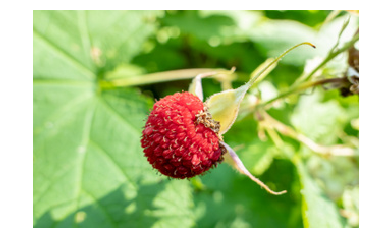

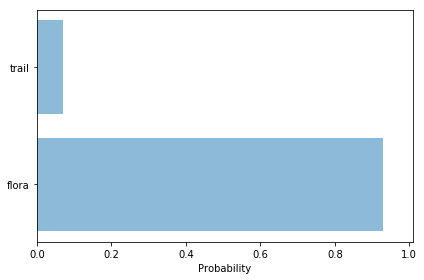

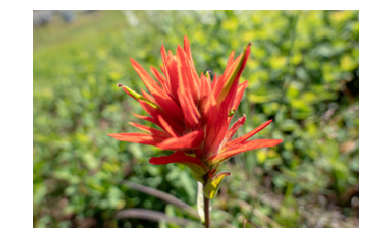

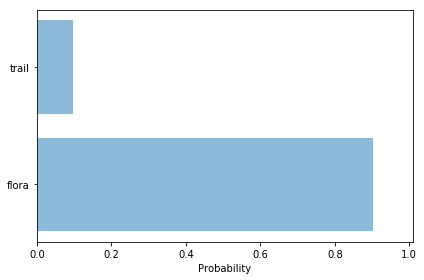

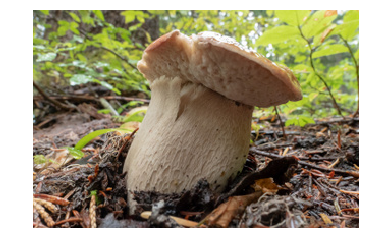

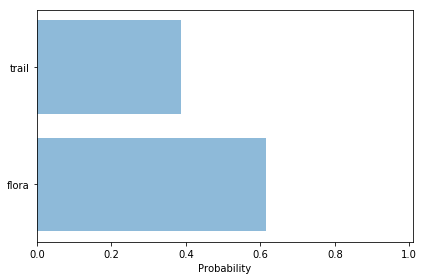

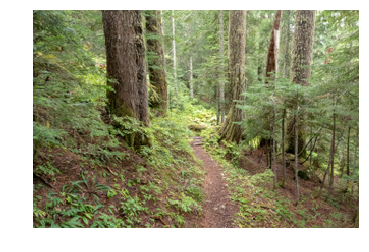

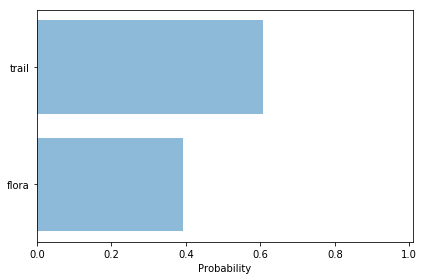

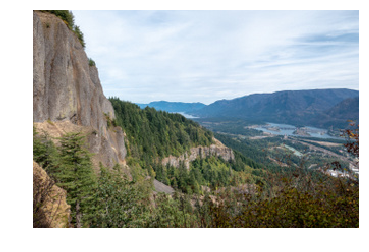

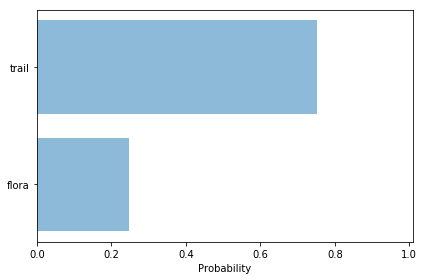

In [9]:
def predict(model, img, img_size):
  if img.size != img_size:
    img = img.resize(img_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]

def plot_preds(img, preds):
  plt.imshow(img)
  plt.axis("off")
  plt.figure()
  labels = ("flora", "trail")
  plt.barh([0, 1], preds, alpha = 0.5)
  plt.yticks([0, 1], labels)
  plt.xlabel("Probability")
  plt.xlim(0,1.01)
  plt.tight_layout()
  plt.show()

for file in os.listdir("data/test"):
    img = Image.open(f"data/test/{file}")
    preds = predict(model, img, (img_width, img_height))
    plot_preds(img, preds)